# Using Natural Language Processing to Generate New Recipes in Python
 Here, I'll be finetuning a distilled version of GPT-2 on a smaller-scale dataset comprising recipes. The recipes are split into ingredients and instructions. Can we use GPT-2 to generate instructions from a list of ingredients?

***Objectives:***
1. How to preprocess and prepare a text dataset comprising recipes.
2. How to launch a training script to finetune a HuggingFace model.
3. How to effectively create a generative model capable of producing realistic recipes when given a list of ingredients.

***Takeaways:***
 - Take raw recipe data, prepare it, load and finetune a distilled verison of GPT-2, and generate realistic, accurate recipes when prompting your model with ingredient lists.

## 1. Introduction
[This is the dataset](https://eightportions.com/datasets/Recipes/#fn:1) we will be using. It is collated by Ryan Lee, sourced from [Food Network](https://www.foodnetwork.com/), [Epicurious](https://www.epicurious.com/), and [Allrecipes](https://www.allrecipes.com/).

### Sample
*Herb Rubbed Sirloin Tip Roast*

- 1 1/4 tablespoons paprika
- 1 tablespoon kosher salt
- 1 teaspoon garlic powder
- 1/2 teaspoon ground black pepper
- 1/2 teaspoon onion powder
- 1/2 teaspoon ground cayenne pepper
- 1/2 teaspoon dried oregano
- 1/2 teaspoon dried thyme
- 2 tablespoons olive oil
- 1 (3 pound) sirloin tip roast

In a small bowl, mix the paprika, kosher salt, garlic powder, black pepper, onion powder, cayenne pepper, oregano, and thyme. Stir in the olive oil, and allow the mixture to sit about 15 minutes.

Preheat oven to 350 degrees F (175 degrees C). Line a baking sheet with aluminum foil.

Place the roast on the prepared baking sheet, and cover on all sides with the spice mixture.

Roast 1 hour in the preheated oven, or to a minimum internal temperature of 145 degrees F (63 degrees C). Let sit 15 minutes before slicing.

In [1]:
!git clone https://github.com/huggingface/transformers;
!cd transformers; pip3 install .

Cloning into 'transformers'...
remote: Enumerating objects: 79300, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (122/122), done.
remote: Total 79300 (delta 57), reused 61 (delta 18), pack-reused 79146
Receiving objects: 100% (79300/79300), 62.33 MiB | 20.81 MiB/s, done.
Resolving deltas: 100% (56677/56677), done.
Processing /content/transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 895 kB 7.0 MB/s 
     |████████████████████████

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
!unzip "/content/drive/MyDrive/ProjectDatasets/NLPGPT2.zip"

Archive:  /content/drive/MyDrive/ProjectDatasets/NLPGPT2.zip
   creating: Dataset/
  inflating: Dataset/LICENSE         
  inflating: Dataset/recipes_raw_nosource_ar.json  
  inflating: Dataset/recipes_raw_nosource_epi.json  
  inflating: Dataset/recipes_raw_nosource_fn.json  
   creating: TrainedModels/
   creating: TrainedModels/Model_10_epochs/
  inflating: TrainedModels/Model_10_epochs/config.json  
  inflating: TrainedModels/Model_10_epochs/merges.txt  
  inflating: TrainedModels/Model_10_epochs/pytorch_model.bin  
  inflating: TrainedModels/Model_10_epochs/special_tokens_map.json  
  inflating: TrainedModels/Model_10_epochs/tokenizer_config.json  
  inflating: TrainedModels/Model_10_epochs/training_args.bin  
  inflating: TrainedModels/Model_10_epochs/vocab.json  
   creating: TrainedModels/Model_20k_steps/
  inflating: TrainedModels/Model_20k_steps/config.json  
  inflating: TrainedModels/Model_20k_steps/merges.txt  
  inflating: TrainedModels/Model_20k_steps/pytorch_model.bin  

In [5]:
from model_demo import demo

demo('Ingredients: 1 cup flour \n 1 cup sugar \n cocoa \n beer \n Instructions:')
#Will not give the same generated output

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


------------------
Generated Output
------------------
Ingredients: 1 cup flour 
 1 cup sugar 
 cocoa 
 beer 
 Instructions: 
 In a large mixing bowl combine flour, sugar, cocoa, and beer. Add beer mixture and mix on low speed until well blended. Transfer to a lightly greased and floured surface and roll into a rectangle. Place dough onto a lightly greased cookie sheet and flatten to form a rectangle. Freeze for at least 1 hour. This makes rolling easier. Preheat oven to 350 degrees F. Bake for 10 minutes or until a toothpick comes out clean. 


## 2. EDA and Preprocessing

In [6]:
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.dpi'] = 200
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
import pandas as pd
import json

In [7]:
data = json.load(open('Dataset/recipes_raw_nosource_ar.json','r'))

In [8]:
keys = list(data.keys())
data[keys[0]]

{'ingredients': ['4 skinless, boneless chicken breast halves ADVERTISEMENT',
  '2 tablespoons butter ADVERTISEMENT',
  '2 (10.75 ounce) cans condensed cream of chicken soup ADVERTISEMENT',
  '1 onion, finely diced ADVERTISEMENT',
  '2 (10 ounce) packages refrigerated biscuit dough, torn into pieces ADVERTISEMENT',
  'ADVERTISEMENT'],
 'instructions': 'Place the chicken, butter, soup, and onion in a slow cooker, and fill with enough water to cover.\nCover, and cook for 5 to 6 hours on High. About 30 minutes before serving, place the torn biscuit dough in the slow cooker. Cook until the dough is no longer raw in the center.\n',
 'picture_link': '55lznCYBbs2mT8BTx6BTkLhynGHzM.S',
 'title': 'Slow Cooker Chicken and Dumplings'}

In [9]:
recipe_sources = ['ar','epi','fn']

In [10]:
df = pd.DataFrame()

sources, titles, ingredients, instructions = [],[],[],[]  

for recipe_source in recipe_sources:
  data = json.load(open(f'Dataset/recipes_raw_nosource_{recipe_source}.json', 'r'))
  
  for _, recipe in data.items():
    if ('title' in recipe) and ('ingredients' in recipe) and ('instructions' in recipe):
      sources.append(recipe_source)
      titles.append(recipe['title'])
      ingredients.append([ingredient.replace('ADVERTISEMENT', '') for ingredient in recipe['ingredients']])
      instructions.append(str(recipe['instructions']).replace('ADVERTISEMENT', '').replace('\n', ' '))
df['source'] = sources
df['title'] = titles
df['ingredients'] = ingredients
df['instructions'] = instructions

In [11]:
df.to_pickle('temp.pkl')

In [12]:
df['ingredient_count'] = df['ingredients'].str.len().fillna(0).astype(int) #If NULL, fill 0
df['instruction_length'] = df['instructions'].str.split().str.len().fillna(0).astype(int)

In [13]:
df.head()

,source,title,ingredients,instructions,ingredient_count,instruction_length
0,ar,Slow Cooker Chicken and Dumplings,"[4 skinless, boneless chicken breast halves , ...","Place the chicken, butter, soup, and onion in ...",6,53
1,ar,Awesome Slow Cooker Pot Roast,[2 (10.75 ounce) cans condensed cream of mushr...,"In a slow cooker, mix cream of mushroom soup, ...",5,44
2,ar,Brown Sugar Meatloaf,"[1/2 cup packed brown sugar , 1/2 cup ketchup ...",Preheat oven to 350 degrees F (175 degrees C)....,11,67
3,ar,Best Chocolate Chip Cookies,"[1 cup butter, softened , 1 cup white sugar , ...",Preheat oven to 350 degrees F (175 degrees C)....,12,74
4,ar,Homemade Mac and Cheese Casserole,"[8 ounces whole wheat rotini pasta , 3 cups fr...",Preheat oven to 350 degrees F. Line a 2-quart ...,14,175


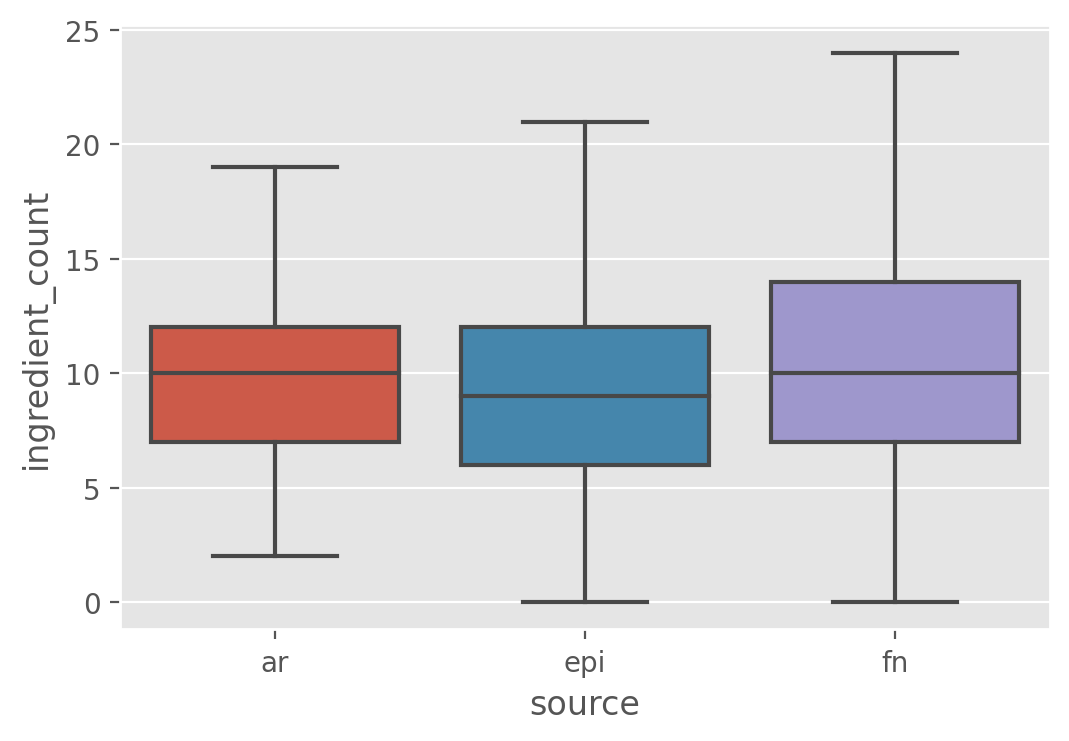

In [14]:
sns.boxplot(data=df, x='source', y='ingredient_count', showfliers = False)
# Source coming from Food Network seems to have slightly more large ingredient count, i.e recipes with more ingredients.

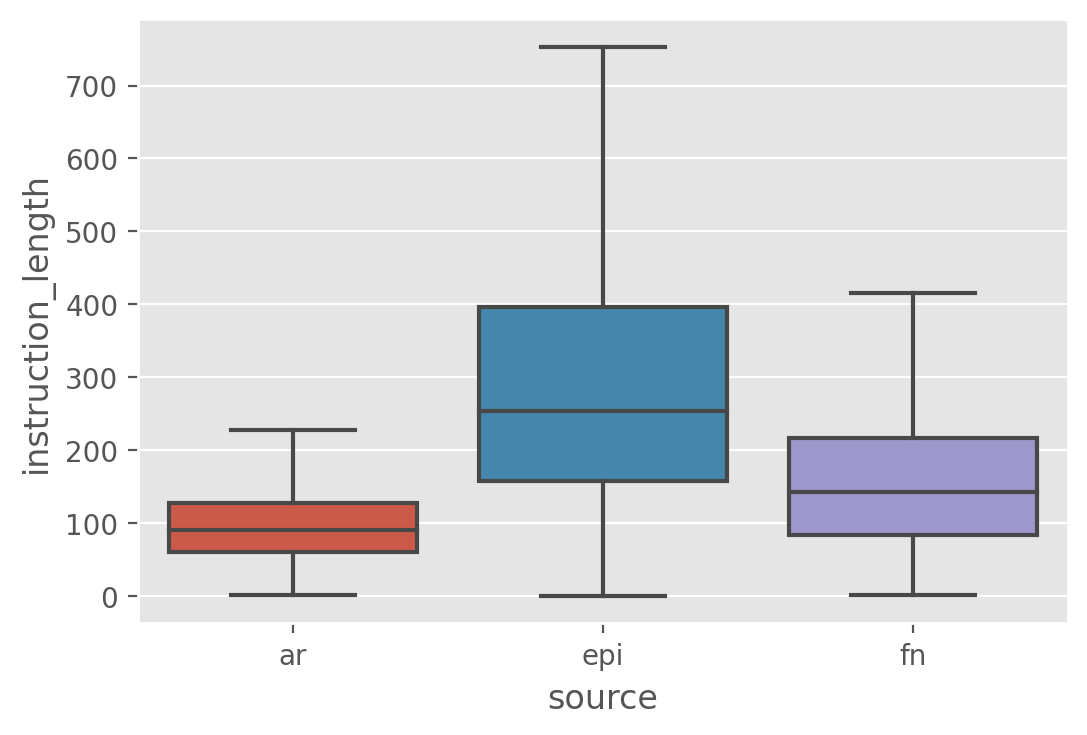

In [15]:
sns.boxplot(data=df, x='source', y='instruction_length', showfliers = False)
# Generally, the source coming from Epicurious recipe seem to have larger instruction length

In [16]:
df.to_pickle('df_recipes_raw.pkl')

## 3. Dataset Preparation

In [17]:
import pandas as pd

In [18]:
df = pd.read_pickle('df_recipes_raw.pkl')

In [19]:
special_token = ' <|endoftext|> '

In [20]:
print(df.shape)

(124647, 6)


In [21]:
df = df[(df.ingredient_count>=3) & (df.instruction_length>=10)]

In [22]:
print(df.shape)

(121780, 6)


In [23]:
# Ingredients: \n Instructions: special_token
df['combined'] = ' \n Ingredients: \n' + df.ingredients.str.join(' \n ') + ' \n Instructions: \n' + df.instructions + special_token

In [24]:
df.iloc[100].ingredients

['1/2 cup butter, melted ',
 '2 eggs, beaten ',
 '1 (8.5 ounce) package dry corn bread mix ',
 '1 (15 ounce) can whole kernel corn, drained ',
 '1 (14.75 ounce) can creamed corn ',
 '1 cup sour cream ',
 '']

In [25]:
df.iloc[100].instructions

'Preheat oven to 350 degrees F (175 degrees C), and lightly grease a 9x9 inch baking dish. In a medium bowl, combine butter, eggs, corn bread mix, whole and creamed corn and sour cream. Spoon mixture into prepared dish. Bake for 45 minutes in the preheated oven, or until the top is golden brown. '

In [26]:
print(df.iloc[100].combined)

 
 Ingredients: 
1/2 cup butter, melted  
 2 eggs, beaten  
 1 (8.5 ounce) package dry corn bread mix  
 1 (15 ounce) can whole kernel corn, drained  
 1 (14.75 ounce) can creamed corn  
 1 cup sour cream  
  
 Instructions: 
Preheat oven to 350 degrees F (175 degrees C), and lightly grease a 9x9 inch baking dish. In a medium bowl, combine butter, eggs, corn bread mix, whole and creamed corn and sour cream. Spoon mixture into prepared dish. Bake for 45 minutes in the preheated oven, or until the top is golden brown.  <|endoftext|> 


In [27]:
df.to_pickle('df_recipes_preprocessed.pkl')

In [28]:
dataset_train = df[:120000].combined.values
dataset_val = df[120000:].combined.values

In [29]:
with open('Dataset/dataset_train.txt', 'w') as f:
  f.write('\n'.join(dataset_train))

with open('Dataset/dataset_val.txt', 'w') as f:
  f.write('\n'.join(dataset_val))

## 4. GPT-2 Pretrained Model Formulation and Theory

In [30]:
#Using transformer library from huggingface.co
from transformers import AutoTokenizer, AutoModelForCausalLM

Here, I will be using a distilled version of Generative Pre-trained Transformer (GPT)-2 NLP model. Essentially, distilled model has a teacher
student relationship between two models. 
<br><br>
I. If you've got a huge model and you've got some inputs, It's trained to predict some label during training. But what actually happens once it's trained?

input > huge_model > label<br>
^ During training
<br><br>
II. Once it's trained, you've got input, a huge model and some very good predictions, which ideally follow these labels very well.

input > huge_model > predictions<br>
^ Trained
<br><br>
III. Distilled model

input > smaller_model > predictions<br>
^ During training
<br>
Now what you do with the Distilled model is you
actually take this trained model and you train a new, smaller model to do the predictions that the big model's doing. So you train a new model to take the inputs and we call it the smaller model, and this is the student model to predict the predictions off the huge model during training. 
<br>
Now the power of this is the Smaller model is actually
learning what they call dark knowledge. It's knowledge that the big model has about its data that might not be present in the label. So, for instance, if you just picture in the vision space, you've got prediction for a Dog, a Cat or a Horse. The huge model is trained to only predict, let's say, a picture of a dog, so it must do 100% Dog
0% Cat 0% Horse.<br>
But when it's trained, what the huge model might actually learn is that dogs and cats have some similar features, so it might say it's 80% sure it's a dog, 19% sure it's a cat and 1% sure that it's a horse.<br>
Now what that does by transferring that kind of knowledge into a smaller model is you're actually learning this dark knowledge, and it's quite
useful.

Hence, I will be using a distilled version of GPT-2 just so that it's much more accessible, much faster to use both for training and for inference.


In [31]:
tokenizer = AutoTokenizer.from_pretrained('distilgpt2')
model = AutoModelForCausalLM.from_pretrained('distilgpt2')

In [32]:
prompt_text = 'Yesterday, I walked to the shop, and'

encoded_prompt = tokenizer.encode(
    prompt_text,
    add_special_tokens=False,
    return_tensors='pt' #or tf
    )
encoded_prompt

tensor([[28065,    11,   314,  6807,   284,   262,  6128,    11,   290]])

In [33]:
#Look at the documentation what each parameters does
output_sequences = model.generate(
    input_ids=encoded_prompt,
    max_length=200,
    temperature=0.9,
    top_k=20,
    top_p=0.9,
    repetition_penalty=1,
    do_sample=True,
    num_return_sequences=2,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [34]:
#output_sequences[0]
tokenizer.decode(output_sequences[0])

'Yesterday, I walked to the shop, and the customer looked over at my laptop, and he was like, "Okay, what about the laptop, you should look at my laptop and see what\'s there?" The customer then called me and told me that I should look into his laptop, and he would go to check the laptop\'s computer.\n\nI did not have a laptop, and it was an iPad, and he had a laptop. He had my laptop and a notebook. I was going to buy a laptop, and I was going to go buy it.\nThen I went to the store. The clerk asked me, "Where is my laptop, I need it?" He said, "I need a laptop. I need the laptop. I need the laptop. I need my laptop. I need my laptop. I need my laptop. I need my laptop. I need my laptop. I need my laptop. I need my laptop. I need my laptop. I need my'

In [35]:
#model.generate?

## 5. HuggingFace Integration and Model Training

In [36]:
#Optional
#!bash run_experiments.sh

## 6. Investigating Finetuning Model Performance

In [37]:
from transformers import AutoTokenizer, AutoModelForCausalLM

In [38]:
tokenizer =  AutoTokenizer.from_pretrained('TrainedModels/Model_10_epochs/')
model = AutoModelForCausalLM.from_pretrained('TrainedModels/Model_10_epochs/')

In [39]:
with open('Dataset/dataset_val.txt','r') as f:
  data = f.read()

In [40]:
special_token = ' <|endoftext|> '

In [41]:
data = data.split(special_token)

In [42]:
data[0]

' \n Ingredients: \n4 tablespoons unsalted butter \n 1 onion, diced \n 1 carrot, peeled and diced \n 1 celery rib, washed and diced \n 4 ears corn, husked and kernels removed \n 6 baby red new potatoes, unpeeled, washed and diced \n 1 quart clam juice \n 1 cup dry white wine \n 3 1/2 pounds Littleneck clams, Manila clams or Cockles in the shell \n 1 Italian Roma tomato, cored, seeded and diced \n 1 red bell pepper, cored, seeded and diced \n 1 jalapeno chile, stemmed, seeded, if desired \n 1 bunch cilantro, leaves only, chopped \n Juice of 1 lime \n 1/2 teaspoon freshly ground black pepper \n Salt to taste \n Instructions: \nMelt the butter in a large stockpot over moderate heat. Saute the onions for 10 minutes. Add the carrots, celery, corn and potatoes and saute 2 minutes longer. Pour in the clam juice. Bring to a boil, reduce to a simmer and cook 30 minutes. Meanwhile, bring the white wine to a boil in a large saucepan and reduce by one-third. Add the clams, cover and steam, shaking

In [43]:
print(data[0])

 
 Ingredients: 
4 tablespoons unsalted butter 
 1 onion, diced 
 1 carrot, peeled and diced 
 1 celery rib, washed and diced 
 4 ears corn, husked and kernels removed 
 6 baby red new potatoes, unpeeled, washed and diced 
 1 quart clam juice 
 1 cup dry white wine 
 3 1/2 pounds Littleneck clams, Manila clams or Cockles in the shell 
 1 Italian Roma tomato, cored, seeded and diced 
 1 red bell pepper, cored, seeded and diced 
 1 jalapeno chile, stemmed, seeded, if desired 
 1 bunch cilantro, leaves only, chopped 
 Juice of 1 lime 
 1/2 teaspoon freshly ground black pepper 
 Salt to taste 
 Instructions: 
Melt the butter in a large stockpot over moderate heat. Saute the onions for 10 minutes. Add the carrots, celery, corn and potatoes and saute 2 minutes longer. Pour in the clam juice. Bring to a boil, reduce to a simmer and cook 30 minutes. Meanwhile, bring the white wine to a boil in a large saucepan and reduce by one-third. Add the clams, cover and steam, shaking the pan occasionall

In [44]:
prompt_text = data[100].split('Instructions:')[0] + '\n Instructions: \n'

In [45]:
print(prompt_text)


 
 Ingredients: 
1 medium banana, peeled and cut into 1/4-inch pieces to yield about 3/4 cup 
 1/4 packed cup light brown sugar 
 1/3 cup finely chopped walnuts 
 16 won ton wrappers 
 1 egg, beaten 
 1/3 cup chocolate-hazelnut spread (recommended: Nutella) or creamy peanut butter 
 Vegetable oil, for frying 
 
 Instructions: 



In [46]:
prompt_text = 'Ingredients: \n 5 eggs \n butter \n cheese \n breadcrumbs \n'
prompt_text += '\n Instructions: '

In [47]:
encoded_prompt = tokenizer.encode(
    prompt_text,
    add_special_tokens=False,
    return_tensors='pt'
)

In [48]:
output_sequences = model.generate(
    input_ids=encoded_prompt,
    max_length=700,
    temperature=0.9,
    top_k=20,
    top_p=0.9,
    repetition_penalty=1,
    do_sample=True,
    num_return_sequences=4,
)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
for i, output_sequence in enumerate(output_sequences):
  result = tokenizer.decode(output_sequence)
  result = result[:result.index(special_token)]
  print('---')
  print(f'Generated Output #{i+1}')
  print('---')
  print(result)